# Libraries

In [1]:
import sys
sys.path.append("../")
from src.noises import add_noise

import torch
from torch import nn

import torchvision
import torchvision.transforms as transforms

from transformers import AutoImageProcessor, ViTMAEModel, ViTMAEForPreTraining, ViTImageProcessor

import cv2
from PIL import Image

import matplotlib.pyplot as plt

import requests

import numpy as np

/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# 1. Applying Transformer Model

## 1.1 Load image and noise it

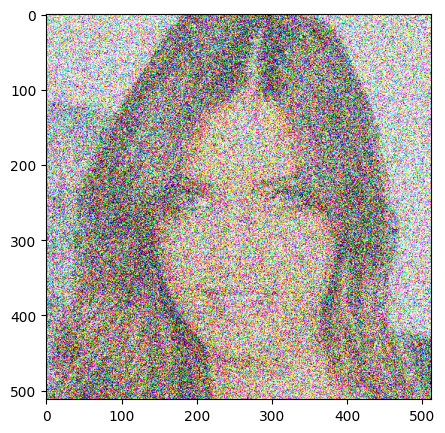

In [3]:
# Load an image using OpenCV
image = cv2.imread('./sample.jpg')

image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

# Add non-Gaussian noise
noisy_image = add_noise(image, noise_type='exponential', scale=100,sigma=150)
noisy_image = add_noise(noisy_image, noise_type='gaussian', scale=100,sigma=150)

fig, ax = plt.subplots(figsize=(5,5))

ax.imshow(noisy_image,cmap='gray')
plt.show()

image = noisy_image.copy()

## 1.2 Load ViTMAE Model and pass image

In [25]:
model.config

ViTMAEConfig {
  "_name_or_path": "facebook/vit-mae-large",
  "architectures": [
    "ViTMAEForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 512,
  "decoder_intermediate_size": 2048,
  "decoder_num_attention_heads": 16,
  "decoder_num_hidden_layers": 8,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "mask_ratio": 0.75,
  "model_type": "vit_mae",
  "norm_pix_loss": false,
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 35,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.37.2"
}

In [37]:
name_model = "facebook/vit-mae-large"


image = noisy_image.copy()
feature_extractor = ViTImageProcessor.from_pretrained(name_model)
model = ViTMAEForPreTraining.from_pretrained(
    name_model,
    num_hidden_layers=35,
    patch_size=20
)

RuntimeError: Error(s) in loading state_dict for ViTMAEForPreTraining:
	size mismatch for vit.embeddings.position_embeddings: copying a param with shape torch.Size([1, 197, 1024]) from checkpoint, the shape in current model is torch.Size([1, 122, 1024]).
	size mismatch for vit.embeddings.patch_embeddings.projection.weight: copying a param with shape torch.Size([1024, 3, 16, 16]) from checkpoint, the shape in current model is torch.Size([1024, 3, 20, 20]).
	size mismatch for decoder.decoder_pos_embed: copying a param with shape torch.Size([1, 197, 512]) from checkpoint, the shape in current model is torch.Size([1, 122, 512]).
	size mismatch for decoder.decoder_pred.weight: copying a param with shape torch.Size([768, 512]) from checkpoint, the shape in current model is torch.Size([1200, 512]).
	size mismatch for decoder.decoder_pred.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1200]).
	You may consider adding `ignore_mismatched_sizes=True` in the model `from_pretrained` method.

In [35]:
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
outputs = model(pixel_values,head_mask=torch.ones(16))

In [30]:
#url = "http://images.cocodataset.org/val2017/000000039769.jpg"
#name_model = "facebook/vit-mae-large"

#image = Image.open(requests.get(url, stream=True).raw)
#image = noisy_image.copy()

#image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")
#feature_extractor = ViTImageProcessor.from_pretrained(name_model)
#model = ViTMAEModel.from_pretrained("facebook/vit-mae-base")
#model = ViTMAEForPreTraining.from_pretrained(
#    name_model,
#    num_hidden_layers=35,
#)

#pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
#outputs = model(pixel_values)

#inputs = image_processor(images=image, return_tensors="pt")
#outputs = model(**inputs)
#last_hidden_states = outputs.last_hidden_state

# 2. Results and comparation

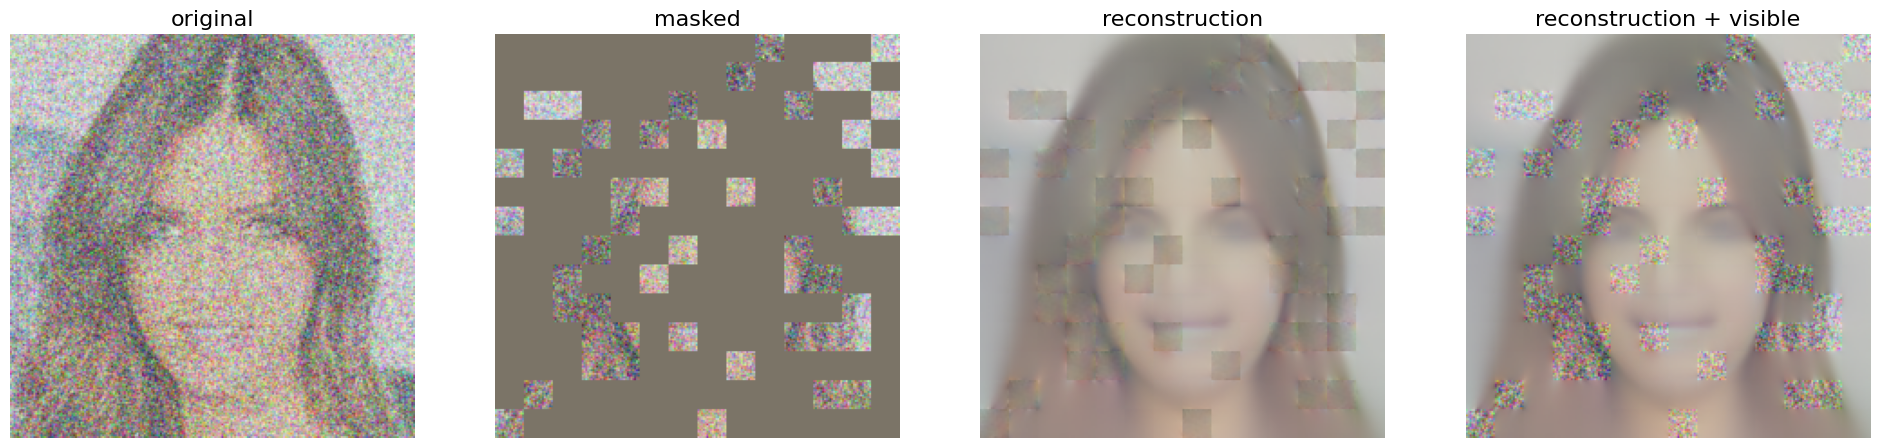

In [36]:
imagenet_mean = np.array(feature_extractor.image_mean)
imagenet_std = np.array(feature_extractor.image_std)

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

y = model.unpatchify(outputs.logits)
y = torch.einsum('nchw->nhwc', y).detach().cpu()

# visualize the mask
mask = outputs.mask.detach()
mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

x = torch.einsum('nchw->nhwc', pixel_values)

# masked image
im_masked = x * (1 - mask)

# MAE reconstruction pasted with visible patches
im_paste = x * (1 - mask) + y * mask

# make the plt figure larger
plt.rcParams['figure.figsize'] = [24, 24]

plt.subplot(1, 4, 1)
show_image(x[0], "original")

plt.subplot(1, 4, 2)
show_image(im_masked[0], "masked")

plt.subplot(1, 4, 3)
show_image(y[0], "reconstruction")

plt.subplot(1, 4, 4)
show_image(im_paste[0], "reconstruction + visible")

plt.show()

# x. Testes

In [23]:
model

ViTMAEForPreTraining(
  (vit): ViTMAEModel(
    (embeddings): ViTMAEEmbeddings(
      (patch_embeddings): ViTMAEPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
    )
    (encoder): ViTMAEEncoder(
      (layer): ModuleList(
        (0-34): 35 x ViTMAELayer(
          (attention): ViTMAEAttention(
            (attention): ViTMAESelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTMAESelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTMAEIntermediate(
            (dense): Linear(in_features=1024, out_feature

In [21]:
pixel_values.shape

torch.Size([1, 3, 224, 224])

In [10]:
outputs.mask.shape

torch.Size([1, 196])

In [22]:
outputs

ViTMAEForPreTrainingOutput(loss=tensor(0.2626, grad_fn=<DivBackward0>), logits=tensor([[[1.2062, 1.3512, 1.5667,  ..., 1.1899, 1.3505, 1.5777],
         [1.2141, 1.3635, 1.5812,  ..., 1.2333, 1.3849, 1.6027],
         [1.2489, 1.3957, 1.6045,  ..., 1.2587, 1.3961, 1.6112],
         ...,
         [0.2492, 0.1425, 0.2890,  ..., 0.4061, 0.3512, 0.1237],
         [0.8524, 0.5295, 0.4937,  ..., 0.8643, 0.8151, 0.8821],
         [0.9759, 0.9458, 1.0383,  ..., 1.1544, 1.2328, 1.3763]]],
       grad_fn=<SliceBackward0>), mask=tensor([[1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
         0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0.,
         0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1.,
         1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
         0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
         1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0.

In [15]:
torch.ones(outputs.mask.shape)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

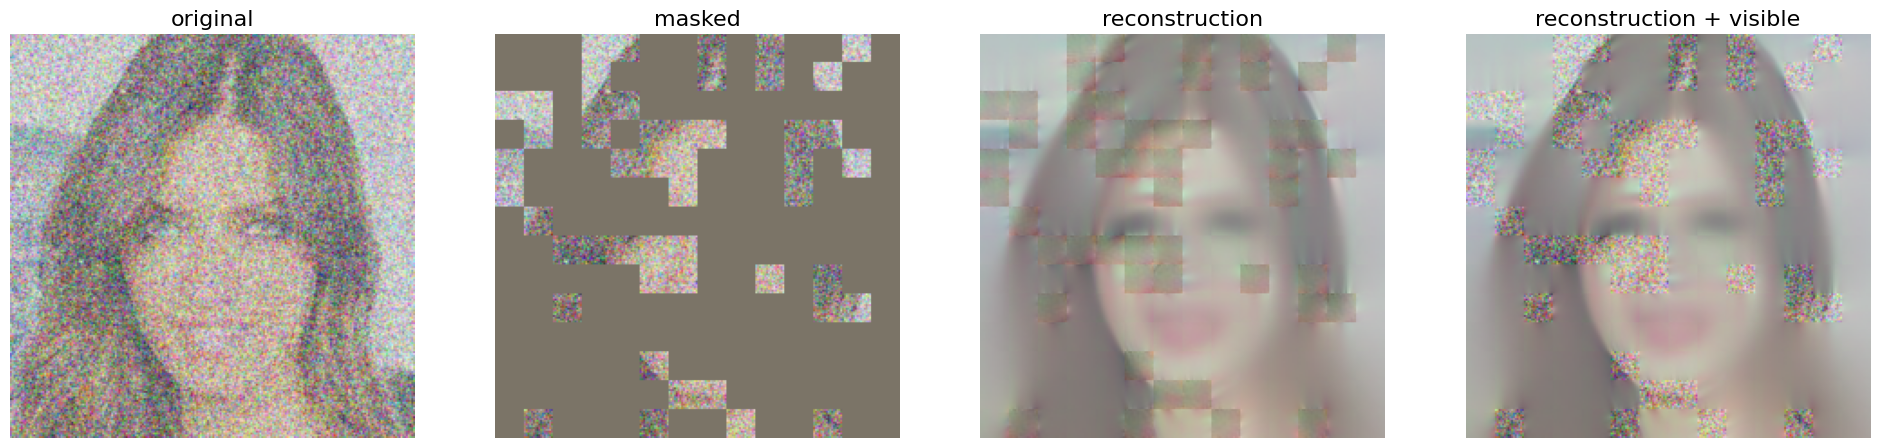

In [72]:
imagenet_mean = np.array(feature_extractor.image_mean)
imagenet_std = np.array(feature_extractor.image_std)

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

y = model.unpatchify(outputs.logits)
y = torch.einsum('nchw->nhwc', y).detach().cpu()

# visualize the mask
mask = outputs.mask.detach()
mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

x = torch.einsum('nchw->nhwc', pixel_values)

# masked image
im_masked = x * (1 - mask)

# MAE reconstruction pasted with visible patches
im_paste = x * (1 - mask) + y * mask

# make the plt figure larger
plt.rcParams['figure.figsize'] = [24, 24]

plt.subplot(1, 4, 1)
show_image(x[0], "original")

plt.subplot(1, 4, 2)
show_image(im_masked[0], "masked")

plt.subplot(1, 4, 3)
show_image(y[0], "reconstruction")

plt.subplot(1, 4, 4)
show_image(im_paste[0], "reconstruction + visible")

plt.show()